# Disparate Impact
Disparate Impact is a fairness metric that measures the ratio of favorable outcomes between unprivileged and privileged groups. It helps identify if a model or decision-making process disproportionately affects different demographic groups.

A value of 1.0 indicates perfect fairness (equal treatment), while values below 1.0 suggest the privileged group receives more favorable outcomes. Values above 1.0 indicate the unprivileged group receives more favorable outcomes.

Below is a table to interpret the results:

| DI Value      | Interpretation                                    | Group Benefiting                      |
| ------------- | ------------------------------------------------ | ------------------------------------- |
| 1.0           | Perfect fairness (equal treatment)               | Neither (equal outcomes)              |
| 0.8 to 1.0    | Minimal disparity                               | Privileged group benefits slightly    |
| 1.0 to 1.2    | Minimal disparity                               | Unprivileged group benefits slightly  |
| 0.6 to 0.8    | Moderate disparity                              | Privileged group benefits             |
| 1.2 to 1.4    | Moderate disparity                              | Unprivileged group benefits           |
| < 0.6         | Significant disparity                           | Privileged group benefits strongly    |
| > 1.4         | Significant disparity                           | Unprivileged group benefits strongly  |

In legal contexts, a Disparate Impact value below 0.8 (or 80%) is often considered evidence of discriminatory impact.

In [13]:
import sys
import os

# Aggiunge la directory principale del progetto al PYTHONPATH
sys.path.append(os.path.abspath(os.path.join('..')))

In [14]:
import fairlib as fl
import matplotlib.pyplot as plt

## Import or dataset creation.
To use metrics, simply use an “enhanced” DataFrame (pandas library). It is possible to create it from the library.
This DataFrame is completely identical to a standard one with some extra functionality.

In [15]:
df = fl.DataFrame({
    "name":     ["Alice", "Bob", "Carla", "Davide", "Elena", "Francesco", "Giorgia", "Hanna", "Luca", "Maria"],
    "age":      [25, 32, 45, 29, 34, 38, 27, 50, 31, 44],
    "sex":      ["F", "M", "F", "M", "F", "M", "F", "F", "M", "F"],
    "income":   [40000, 38000, 43400, 43000, 48000, 49000, 42000, 41000, 47000, 40000]
})

We go on to define which columns we consider sensitive and the “target” column then the one we would like to predict

In [16]:
df.sensitive = {"age", "sex"}
df.targets = {"income"}

In order to invoke the DI on our dataset we need to do some preprocessing, so let's go and change the column values based on binary values.

In [17]:
df.discretize(
    ("male", df.sex == 'M'),
    age=("age<38", lambda age: age < 38),
    income=("income>45k", lambda income: income > 45000),
    in_place=True,
)

,name,male,age<38,income>45k
0,Alice,False,True,False
1,Bob,True,True,False
2,Carla,False,False,False
3,Davide,True,True,False
4,Elena,False,True,True
5,Francesco,True,False,True
6,Giorgia,False,True,False
7,Hanna,False,False,False
8,Luca,True,True,True
9,Maria,False,False,False


Once this is done we can call the statistical parity difference directly on the dataframe.

In [18]:
spd = df.disparate_impact()

print(spd)

{(not(income>45k), not(male)): 0.6, (not(income>45k), male): 1.6666666666666667, (income>45k, not(male)): 3.0, (income>45k, male): 0.3333333333333333, (not(income>45k), not(age<38)): 0.8888888888888888, (not(income>45k), age<38): 1.125, (income>45k, not(age<38)): 1.3333333333333333, (income>45k, age<38): 0.75}


## Interpretation of the results

As we can see there is a clear disparity for gender.
And a slight disparity for age.

This means that female subjects in the previous dataset are much less likely to have an income higher than 45000

In [19]:
labels = list(spd[{'income>45k': True}].keys())
values = list(spd[{'income>45k': True}].values())

In [20]:
labels = [f"{item1}, {item2}" for item1, item2 in labels]

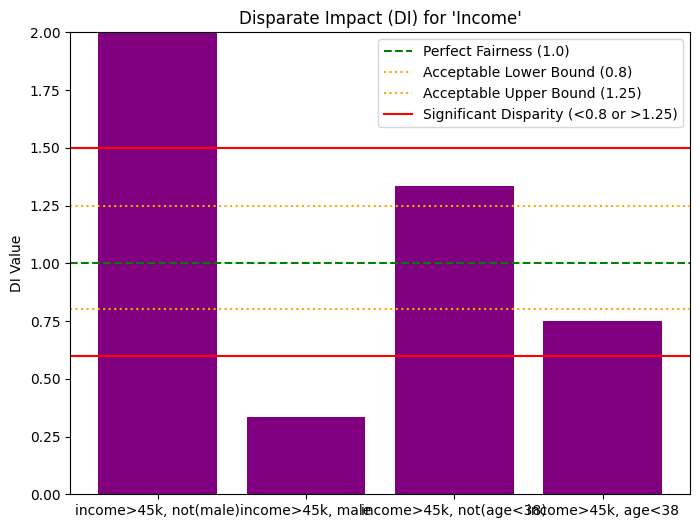

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

# Linea di riferimento per Disparate Impact ideale
ax.axhline(y=1.0, color='green', linestyle='--', label="Perfect Fairness (1.0)")

# Soglie della regola dell'80%
ax.axhline(y=0.8, color='orange', linestyle=':', label="Acceptable Lower Bound (0.8)")
ax.axhline(y=1.25, color='orange', linestyle=':', label="Acceptable Upper Bound (1.25)")

# Linee per disparità significativa
ax.axhline(y=0.6, color='red', linestyle='-', label="Significant Disparity (<0.8 or >1.25)")
ax.axhline(y=1.5, color='red', linestyle='-')

# Barre dei modelli
ax.bar(labels, values, color='purple')

ax.set_title("Disparate Impact (DI) for 'Income'")
ax.set_ylabel("DI Value")
ax.set_ylim([0, 2])
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)

ax.legend()
plt.show()